In [1]:
import os

import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
# import tensorflow_io as tfio
from tensorflow.keras import layers
from tensorflow import keras
import matplotlib.pyplot as plt
# from PIL import Image, ImageFilter, ImageEnhance
import random

print(tf.__version__)

2.6.2


In [2]:
IMG_HEIGHT = 176
IMG_WIDTH = 128

In [3]:
image_gen = keras.preprocessing.image.ImageDataGenerator(rotation_range=50, brightness_range=[0.5,1], 
                                                         zoom_range=0.4, validation_split=0.1)

image_gen = keras.preprocessing.image.ImageDataGenerator.flow_from_directory(image_gen, directory="Data", 
                        target_size=(IMG_HEIGHT,IMG_WIDTH), color_mode='rgb')

Found 14682 images belonging to 12 classes.


## Get class weights to help with balancing the data maybe

In [4]:
main_folder = "Data/"
total_samples = image_gen.samples
classes = image_gen.class_indices
nClass = image_gen.num_classes

class_weights = {}
counts = [0 for n in range(nClass)]

for key, val in classes.items():
    counts[val] = len(os.listdir(main_folder+key))

max_count = max(counts)

print(f'{"key":^20s} {"count":^10s} {"class_weights":^10s}')
for key, val in classes.items():
    class_weights[val] = max_count/counts[val]
    print(f'{key:20s} {counts[val]:7.1f} {class_weights[val]:10.3f}')

        key            count    class_weights
fresh_apple           1693.0      1.383
fresh_banana          1581.0      1.481
fresh_bitter_gourd     327.0      7.162
fresh_capsicum         990.0      2.366
fresh_orange          1466.0      1.598
fresh_tomato           981.0      2.387
stale_apple           2342.0      1.000
stale_banana          1467.0      1.596
stale_bitter_gourd     357.0      6.560
stale_capsicum         901.0      2.599
stale_orange          1595.0      1.468
stale_tomato           982.0      2.385


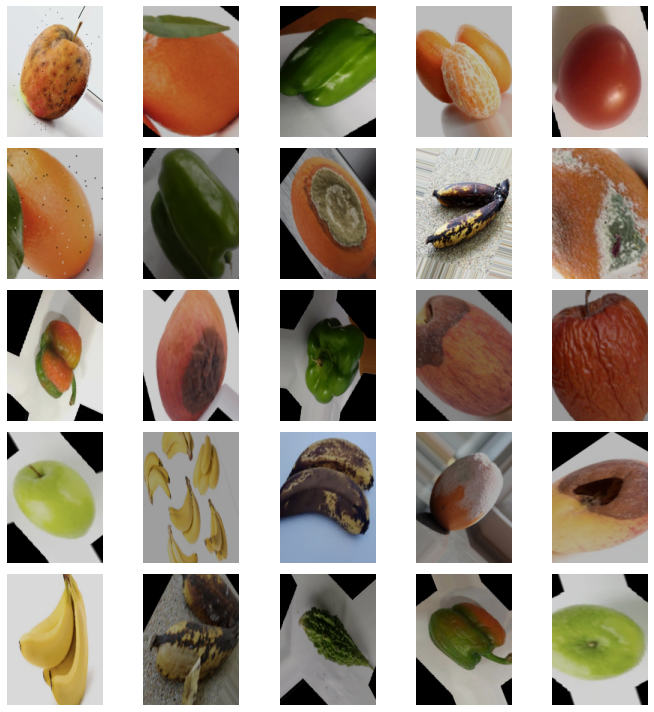

In [5]:
# Display the generator output
x_train = image_gen.next()

n = 5
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(10,10))
for i in range(n**2):
    ax = axs[i // n, i % n]
    ax.imshow(x_train[0][i,:,:,:]/255)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [9]:
model_base = keras.applications.MobileNetV3Small(input_shape=(IMG_HEIGHT, IMG_WIDTH,3),
                                                 include_top=False,
    weights='imagenet',
    dropout_rate=0.2,
    include_preprocessing=False)
model_base.trainable = False



inputs = layers.Input((IMG_HEIGHT, IMG_WIDTH,3))

x = layers.Lambda(lambda x: x/255) (inputs)

x = model_base(x, training=False)
x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(rate=.3)(x)

x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(rate=.3)(x)    

x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(rate=.3)(x)  

outputs = layers.Dense(image_gen.num_classes, activation='softmax')(x)


model = keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', 
              metrics=['accuracy']) 

model.summary()

2022-01-31 19:10:01.189272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 19:10:01.189593: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 19:10:01.189848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 19:10:01.438178: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 19:10:01.438447: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 176, 128, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 176, 128, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 1, 1024)        4096      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

In [12]:
import math
## TODO: make a validation generator

batch_size = 32
history = model.fit(image_gen, 
          steps_per_epoch=math.ceil(image_gen.samples//batch_size),
          class_weight=class_weights,
          epochs=30)

Epoch 1/30
458/458 [==============================] - 76s 166ms/step - loss: 0.1354 - accuracy: 0.9766
Epoch 2/30
458/458 [==============================] - 76s 166ms/step - loss: 0.1430 - accuracy: 0.9771
Epoch 3/30
458/458 [==============================] - 77s 167ms/step - loss: 0.1335 - accuracy: 0.9747
Epoch 4/30
458/458 [==============================] - 75s 165ms/step - loss: 0.1245 - accuracy: 0.9758
Epoch 5/30
458/458 [==============================] - 76s 166ms/step - loss: 0.1207 - accuracy: 0.9800
Epoch 6/30
458/458 [==============================] - 76s 167ms/step - loss: 0.1181 - accuracy: 0.9787
Epoch 7/30
458/458 [==============================] - 76s 166ms/step - loss: 0.1284 - accuracy: 0.9794
Epoch 8/30
458/458 [==============================] - 76s 165ms/step - loss: 0.1730 - accuracy: 0.9765
Epoch 9/30
458/458 [==============================] - 75s 165ms/step - loss: 0.1265 - accuracy: 0.9773
Epoch 10/30
458/458 [==============================] - 76s 166ms/step - l

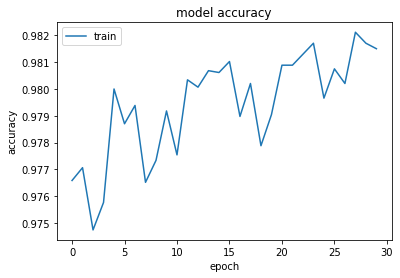

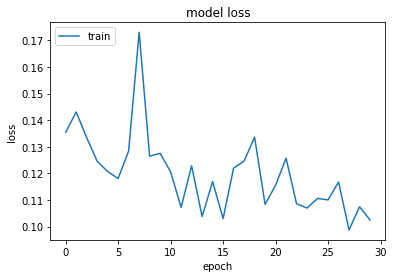

In [13]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Fine-tune

In [14]:
model_base.trainable = True

model.compile(optimizer=keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', 
              metrics=['accuracy']) 

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 176, 128, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 176, 128, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1, 1, 1024)        1529968   
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 1, 1024)        4096      
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

In [15]:
batch_size = 32
history = model.fit(image_gen, 
          steps_per_epoch=math.ceil(image_gen.samples//batch_size),
          class_weight=class_weights,
          epochs=10)

Epoch 1/10
458/458 [==============================] - 78s 166ms/step - loss: 0.1016 - accuracy: 0.9844
Epoch 2/10
458/458 [==============================] - 76s 166ms/step - loss: 0.1011 - accuracy: 0.9838
Epoch 3/10
458/458 [==============================] - 76s 166ms/step - loss: 0.0805 - accuracy: 0.9864
Epoch 4/10
458/458 [==============================] - 76s 165ms/step - loss: 0.0533 - accuracy: 0.9898
Epoch 5/10
458/458 [==============================] - 77s 167ms/step - loss: 0.0452 - accuracy: 0.9915
Epoch 6/10
458/458 [==============================] - 76s 166ms/step - loss: 0.0691 - accuracy: 0.9891
Epoch 7/10
458/458 [==============================] - 76s 166ms/step - loss: 0.0526 - accuracy: 0.9892
Epoch 8/10
458/458 [==============================] - 76s 165ms/step - loss: 0.0465 - accuracy: 0.9907
Epoch 9/10
458/458 [==============================] - 76s 167ms/step - loss: 0.0444 - accuracy: 0.9924
Epoch 10/10
458/458 [==============================] - 77s 168ms/step - l

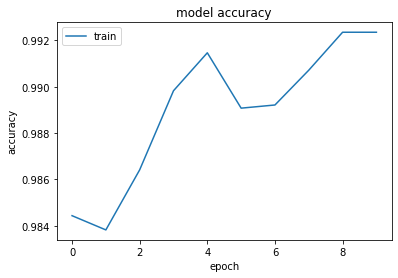

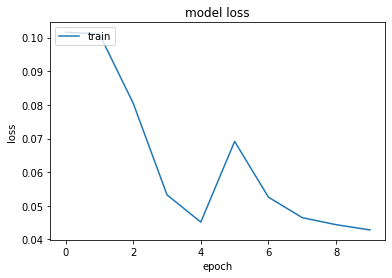

In [16]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [17]:
# Converting a tf.Keras model to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('FreshnessFGclassifier2WxH_128x176.tflite', 'wb') as f:
    f.write(tflite_model)

2022-01-31 21:16:46.280677: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: /tmp/tmppg2yn4va/assets


/home/rimogardino/miniconda3/envs/tfgpu3/lib/python3.9/site-packages/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
2022-01-31 21:16:53.658215: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-31 21:16:53.658393: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2022-01-31 21:16:53.658439: I tensorflow/core/grappler/clusters/single_machine.cc:357] Starting new session
2022-01-31 21:16:53.658576: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA 